In [72]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
from datetime import datetime 
import pandas as pd
import attr
import math
import typing
import xlwings as xw
import time

In [93]:
@attr.s
class twoFactorHW:
    market_curve: ql.YieldTermStructure = attr.ib(default=ql.FlatForward(2, ql.TARGET(), 0.03, ql.Actual360()))
    today_date: ql.Date = attr.ib(default=ql.Date.from_date(datetime.today()))
    a: float = attr.ib(default=0.03)
    sigma: float = attr.ib(default=0.0042)
    b: float = attr.ib(default = 0.03)
    eta: float = attr.ib(default=0.0042)
    rho : float = attr.ib(default= 0.70)
    
    def makeSwap(self, maturity: int, EurIndex: "eur6m or eur3m", strike= ql.nullDouble(), nominal = 1e6 ):
        ql.Settings_instance().setEvaluationDate(self.today_date)
        self.market_curve.enableExtrapolation()
        relink_curve = ql.RelinkableYieldTermStructureHandle()
        relink_curve.linkTo(self.market_curve)
        swp_engine = ql.DiscountingSwapEngine(relink_curve)
        if EurIndex == "eur6m":
            index = ql.Euribor6M(relink_curve)
            vanilla_swap = ql.MakeVanillaSwap(ql.Period(maturity, ql.Years), index, strike, ql.Period('0d'), 
                                      fixedLegTenor=ql.Period('12m'),
                                      pricingEngine=swp_engine, Nominal = nominal)
        elif EurIndex == "eur3m":
            index = ql.Euribor3m(relink_curve)
            vanilla_swap = ql.MakeVanillaSwap(ql.Period(maturity, ql.Years), index, strike, ql.Period('0d'), 
                                                  fixedLegTenor=ql.Period('12m'),
                                                  pricingEngine=swp_engine, Nominal = nominal)
        return relink_curve, index, vanilla_swap
    
    def phi(self, t: float) -> float:  # pagina 146 Brigo-Mercurio
        f = self.market_curve.forwardRate(t, t+0.002739726, ql.Continuous).rate() # t+ 1 giorno
        exp_at = 1- np.exp(-self.a*t)
        exp_bt = 1- np.exp(-self.b*t)
        phi_t = f + (self.sigma**2/(2*self.a**2)) * (exp_at**2) 
        + (self.eta**2/(2*self.b**2)) * (exp_bt**2) + self.rho *(self.sigma*self.eta/(self.a*self.b))*exp_at*exp_bt
        return phi_t

    def x_t_s(self, t: float, s: float , x_s:float):
        dt = t-s
        E_xt = x_s * np.exp(-self.a*dt)
        var_xt = (self.sigma**2/(2*self.a))*(1-np.exp(-2*self.a*dt))
        return np.random.normal(loc= E_xt, scale=math.sqrt(var_xt))
    
    def y_t_s(self, t:float, s:float, y_s:float):
        a = self.a 
        sigma = self.sigma
        b = self.b
        eta = self.eta
        rho = self.rho
        dt = t-s
        decay_factor_2b = 1 - np.exp(-2*b*dt)
        decay_factor_cross = 1 - np.exp(-(a+b)*dt)
        E_yt = y_s * np.exp(-b*dt)
        var_yt = (eta**2/(2*b))*decay_factor_2b + 2*rho*sigma*eta/(a+b) * decay_factor_cross
        return np.random.normal(loc= E_yt, scale=math.sqrt(var_yt))

    def gauss_params(self, s: float, t: float, r_s: float, x_s, y_s) -> typing.Tuple[float, float]:
        a = self.a 
        sigma = self.sigma
        b = self.b
        eta = self.eta
        rho = self.rho
        dt = t-s
        decay_factor_a = np.exp(-a*dt)
        decay_factor_b = np.exp(-b*dt)
        decay_factor_2a = 1 - np.exp(-2*a*dt)
        decay_factor_2b = 1 - np.exp(-2*b*dt)
        decay_factor_cross = 1 - np.exp(-(a+b)*dt)
        E_rt = x_s*decay_factor_a + y_s*decay_factor_b + self.phi(t)
        Var_rt = (sigma**2 / (2*a)) * decay_factor_2a + (eta**2/(2*b))*decay_factor_2b
        + 2*rho*sigma*eta/(a+b) * decay_factor_cross
        return E_rt, Var_rt
    
    def short_rate_path(self, path_length: float, 
                        path_steps: float,
                        times: np.array = None) -> typing.Tuple[np.array, np.array]:
        if times is None:
            times, dt = np.linspace(start=0.0, stop=path_length, num=path_steps, retstep=True)
        rt_path = np.zeros_like(times)
        x_t = np.zeros_like(times)
        y_t = np.zeros_like(times)
        rt_path[0] = self.market_curve.forwardRate(0, 0, ql.Continuous).rate()
        xs = 0
        ys = 0
        for step, tpl in enumerate(zip(times[:-1], times[1:]), 1):
            s, t = tpl
            xt = self.x_t_s(t, s, x_t[step -1])
            yt = self.y_t_s(t, s, y_t[step -1])
            rt = xt +yt + self.phi(t)
            x_t[step] = xt
            y_t[step] = yt
            rt_path[step] = rt
        return times, rt_path, x_t, y_t
    
    def compute_V(self,t,T):
        a = self.a
        sigma = self.sigma
        b= self.b
        eta = self.eta
        rho = self.rho
        dt = T-t
        v1 = (sigma**2/a**2)*(dt +(2/a)*np.exp(-a*dt) - (1/(2*a))*np.exp(-2*a*dt) - 3/(2*a))
        v2 = (eta**2/b**2) * (dt + (2/b)*np.exp(-b*dt) - (1/(2*b))*np.exp(-2*b*dt) - 3/(2*b))
        v12 = 2*rho*(sigma*eta/(a*b))*(dt + (np.exp(-a*dt)-1)/a + (np.exp(-b*dt)-1)/b + (np.exp(-(a+b)*dt)-1)/(a+b))
        v_t_T = v1 + v2 + v12
        return v_t_T
    
    def compute_A(self,t,T, x_t, y_t):
        a = self.a
        b= self.b
        M_t_T = ((1-np.exp(-a*(T-t)))/a)*x_t + ((1-np.exp(-a*(T-t)))/a)*y_t
        A_t_T = (1/2)*(self.compute_V(t,T) - self.compute_V(0,T) + self.compute_V(0,t)) - M_t_T
        return A_t_T
    
    def ZCB_price(self, t, T, x_t, y_t): 
        P0T = self.market_curve.discount(T, True)
        P0t = self.market_curve.discount(t, True)
        P_t_T = (P0T/P0t) * np.exp(self.compute_A(t,T,x_t,y_t))
        return P_t_T
    
    def future_discount_curve(self, future_date, xt, yt) -> ql.YieldTermStructure:
        """ 
        This function returns a Quantlib DiscountCurve
        at a future reference date. The curve is based on 
        160 pillars each at 3m distance.

        Parameters :
        future_date : future reference date of the curve.


        Returns :
        QuantLib DiscountCurve object at future reference
        date.
        """
        curve_calendar = self.market_curve.calendar()
        dcf = self.market_curve.dayCounter()
        future_date_t = dcf.yearFraction(self.today_date, future_date)
        final_date = curve_calendar.advance(future_date, ql.Period('20y'), ql.Unadjusted)
        curve_dates = list(ql.MakeSchedule(future_date, final_date, tenor=ql.Period('3m'))) #161
        dts = np.array([dcf.yearFraction(d1, d2) for d1, d2 in zip(curve_dates[:-1], curve_dates[1:])])
        dts = dts.cumsum()
        dts += future_date_t
        future_discount_factors = np.zeros(len(dts)+1)
        future_discount_factors[0] = 1.0
        for ix, T in enumerate(dts):
            future_discount_factors[ix+1] = self.ZCB_price(future_date_t, T, xt, yt)
        return ql.DiscountCurve(curve_dates, future_discount_factors, dcf, curve_calendar)
    
    def curves_path(self, simulation_dates):
        """
        This function returns a list of DiscountCurves at different 
        future dates according to the simulated short rate.

        Parameters : 
        simulation_dates : list of future ql.Date at which discount curve 
                           is simulated.

        Returns : 
        List of ql.DiscountCurve objects representing the future evolution 
        of the discount curve.
        """
        curve_calendar = self.market_curve.calendar()
        dcf = self.market_curve.dayCounter()
        path_times = [dcf.yearFraction(d1, d2) for d1, d2 in zip(simulation_dates[:-1], simulation_dates[1:])]
        path_times = np.array([0] + path_times).cumsum()
        _, _, xts, yts = self.short_rate_path(0, 0, path_times.cumsum())
        return [self.future_discount_curve(d, x, y) for d, x, y in zip(simulation_dates, xts, yts)]       
   
    def MCsimul(self, Nsimul: int, maturity, eurIndex: str ):
        """
        Simulation of the swap for a given number of call dates
        Returns:
        Swap NPV,  Floating Leg NPV,  Fixed Leg NPV, Swap Fair Rate
        """
        setts = ql.Settings_instance()
        relink_curve, index, vanilla_swap = self.makeSwap(maturity, eurIndex)
        swp_engine = ql.DiscountingSwapEngine(relink_curve)
        swap_fixing_dates = [index.fixingDate(d) for d in vanilla_swap.floatingSchedule()]
        swap_fixed_schedule = list(vanilla_swap.fixedSchedule())
        swap_call_dates = [calendar.advance(d, ql.Period('-2d')) for d in swap_fixed_schedule[:-1]]
        simulation_calendar = index.fixingCalendar()
        simulation_end = simulation_calendar.advance(vanilla_swap.maturityDate(), ql.Period('-1d'))
        simulation_dates = swap_call_dates +swap_fixing_dates 
        simulation_dates = sorted(set(simulation_dates))
        NPV_fixedLeg = []
        NPV_floatingLeg = []
        NPV_swap = []
        swap_fairRate = []
        for path in range(0,Nsimul):
            setts.setEvaluationDate(todayd)
            curve_sim = self.curves_path(simulation_dates)
            fixNPV = []
            floatNPV = []
            swpNPV = []
            swapRate = []
            for ix, d in enumerate(simulation_dates):
                crv = curve_sim[ix]
                relink_curve.linkTo(crv)
                setts.setEvaluationDate(d)
                fixing = crv.zeroRate(0.5, ql.Simple).rate()
                index.addFixing(d, fixing, forceOverwrite=True)
                if d in swap_call_dates:
                    fixNPV.append(vanilla_swap.fixedLegNPV())
                    floatNPV.append(vanilla_swap.floatingLegNPV())
                    swpNPV.append(vanilla_swap.NPV())
                    swapRate.append(vanilla_swap.fairRate())
            NPV_fixedLeg.append(fixNPV)
            NPV_floatingLeg.append(floatNPV)
            NPV_swap.append(swpNPV)
            swap_fairRate.append(swapRate)
        NPV_swap = np.array(NPV_swap).T
        NPV_floatingLeg = np.array(NPV_floatingLeg).T
        NPV_fixedLeg = np.array(NPV_fixedLeg).T
        swap_fairRate = np.array(swap_fairRate).T
        return swap_call_dates, NPV_swap, NPV_floatingLeg, NPV_fixedLeg, swap_fairRate
    
    def npv_LSM(self, Nsimul, maturity, eurIndex):
        swap_call_dates, NPV_swap, NPV_floatingLeg, NPV_fixedLeg, swap_fairRate = self.MCsimul(Nsimul, maturity, eurIndex)
        setts.setEvaluationDate(todayd)
        NPV_swap[NPV_swap<0] = 0
        m = len(swap_call_dates) -1
        #m = len(swap_call_dates)
        payoff = NPV_swap
        V = np.zeros_like(payoff)
        V[-1] = payoff[-1]
        ###### disc factors date to date #######
        time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(todayd, x))(swap_call_dates)
        df = np.zeros(len(time_grid))
        for i, data in enumerate(time_grid):
            df[i] = self.ZCB_price(0,data,0,0)
            t = data
        for t in range(m-1, 0, -1):
            rg = np.polyfit(swap_fairRate[t,:], V[t+1 ,:]*df[t], 5)  
            C = np.polyval(rg, NPV_swap[t,:]) 
            V[t,:] = np.where(payoff[t,:] > C, payoff[t,:], V[t+1]* df[t])
        return np.sum(V[1,:]*df[1]) / Nsimul

In [94]:
calendar = ql.TARGET()
todayd = ql.Date.from_date(datetime.today())
setts = ql.Settings_instance()
setts.setEvaluationDate(todayd)
myhw = twoFactorHW(a=0.03, sigma = 0.0075, b = 0.05, eta = 0.0035, rho = 0.02)
#myhw = twoFactorHW(a=0.0000001, sigma = 0.000000001, b = 0.0000001, eta = 0.0000001, rho = 0.0000001)
myhw.market_curve.enableExtrapolation()

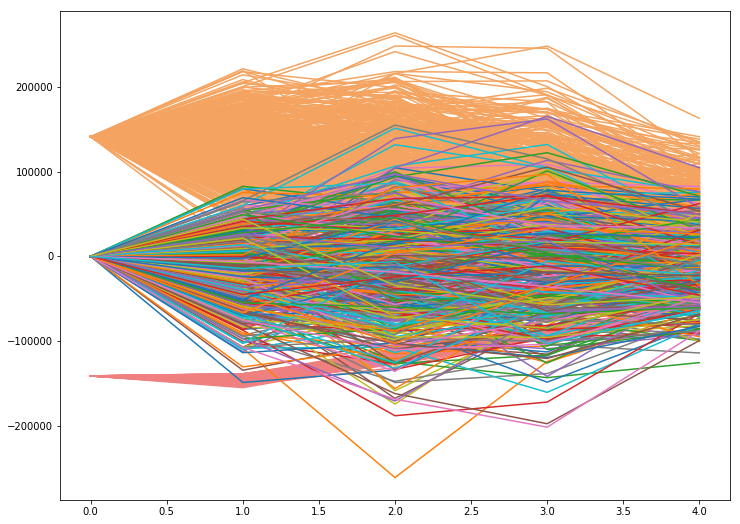

In [7]:
swap_call_dates,NPV_swap, NPV_floatingLeg, NPV_fixedLeg, swap_fairRate = myhw.MCsimul(500, 5, "eur6m")

fig = plt.figure(figsize=(12,9))
plt.plot(NPV_fixedLeg, color = "lightcoral")
plt.plot( NPV_floatingLeg, color = "sandybrown")
plt.plot( NPV_swap)
plt.show()

In [95]:
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(todayd, x))(swap_call_dates)

In [96]:
time_grid

array([0.        , 1.00821918, 2.00821918, 3.00821918, 4.00547945])

In [97]:
myhw.npv_LSM(12000, 5, "eur6m")

14215.849864486081

In [ ]:
13996 #1k

In [ ]:
15492.33614004654   ### 2k 

In [ ]:
6937 #3k

In [ ]:
16174.105845842865 #4k 

In [ ]:
6135.471638687147 #10 k

In [ ]:
14215 #12k

In [56]:
calendar = ql.TARGET()
todayd = ql.Date.from_date(datetime.today())
setts = ql.Settings_instance()
setts.setEvaluationDate(todayd)
relink_curve = ql.RelinkableYieldTermStructureHandle()
#relink_curve.linkTo(eur6m_discount_curve)
relink_curve.linkTo(myhw.market_curve)
eur6m_index = ql.Euribor6M(relink_curve)
swp_engine = ql.DiscountingSwapEngine(relink_curve)
setts.setEvaluationDate(todayd)
relink_curve.linkTo(myhw.market_curve)
vanilla_swap = ql.MakeVanillaSwap(ql.Period('5y'), eur6m_index, ql.nullDouble(), ql.Period('0d'), 
                                  fixedLegTenor=ql.Period('12m'),
                                  pricingEngine=swp_engine, Nominal=1e6)
HWmodel = ql.HullWhite(relink_curve, a = 0.03, sigma= 0.0075)
G2model = ql.G2(relink_curve, a = 0.03, sigma = 0.0075, b = 0.05, eta = 0.0035, rho = 0.02)
HWmodel2 = ql.HullWhite(relink_curve, a = 0.03, sigma = 0.0075)
BKmodel = ql.BlackKarasinski(relink_curve, a = 0.03, sigma= 0.0075)
exercise = ql.BermudanExercise(swap_call_dates)
swaption = ql.Swaption(vanilla_swap, exercise)
swaptionEngine = ql.TreeSwaptionEngine(HWmodel, 50)
swaption.setPricingEngine(swaptionEngine)


In [57]:
swaption.NPV()

14272.796290286182

In [58]:
atm = vanilla_swap.fairRate()
strike = [-0.1, -0.075, -0.050, - 0.025, 0, 0.025, 0.050, 0.075, 0.1]

In [64]:
bermuda_hw = np.zeros(len(strike))
bermuda_G2 = np.zeros(len(strike))
bermuda_HW2 = np.zeros(len(strike))
for i, k in enumerate(strike):
    vanilla_swap = ql.MakeVanillaSwap(ql.Period('5y'), eur6m_index, atm + k, ql.Period('0d'), 
                                  fixedLegTenor=ql.Period('12m'),
                                  pricingEngine=swp_engine, Nominal=1e6)
    swaption = ql.Swaption(vanilla_swap, exercise)
    TreeswaptionEngine = ql.TreeSwaptionEngine(HWmodel, 50)
    swaption.setPricingEngine(TreeswaptionEngine)
    bermuda_hw[i] = swaption.NPV()

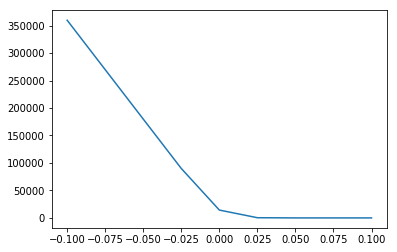

In [65]:
plt.plot(strike, bermuda_hw)

#### LS a manella 

In [125]:
NPV_swap[NPV_swap<0] = 0

In [126]:
m = len(swap_call_dates) -1
payoff = NPV_swap

In [127]:
V = np.zeros_like(payoff)
V[-1] = payoff[-1]

In [128]:
setts.setEvaluationDate(todayd)
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(todayd, x))(swap_call_dates)
df = np.zeros(len(time_grid))
for i, data in enumerate(time_grid):
    df[i] = myhw.ZCB_price(0,data,0,0)
    t = data

In [123]:
for t in range(m-1, 0, -1):
    rg = np.polyfit(swap_fairRate[t,:], V[t+1 ,:]*df[t], 5)  
    C = np.polyval(rg, NPV_swap[t,:]) 
    V[t,:] = np.where(payoff[t,:] > C, payoff[t,:], V[t+1]* df[t])

IndexError: too many indices for array

In [104]:
npv_LSM = np.sum(V[1,:]*df[0]) / Nsimul # LSM estimator

TypeError: 'int' object is not subscriptable

In [99]:
npv_LSM

NameError: name 'npv_LSM' is not defined

In [129]:
len(df)

5

In [133]:
n = 1  
maturity = swap_fairRate[4,:]
reference = swap_fairRate[4 - n,:]
payoff = NPV_swap[4,:]*df[4]

rg   = np.polyfit(reference, payoff, 5)
yy   = np.polyval(rg, reference)

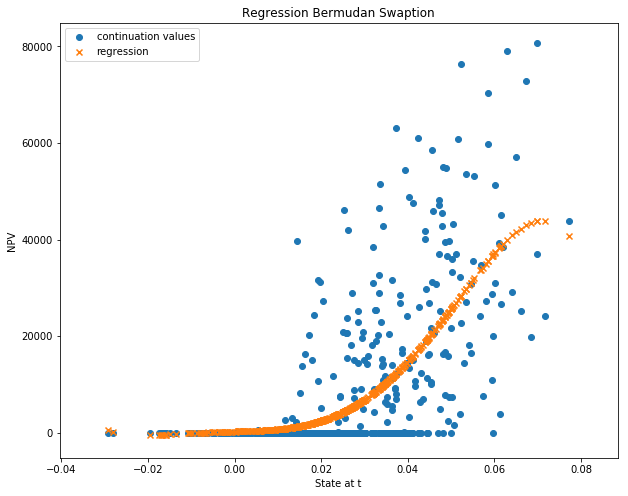

In [134]:
plt.figure(figsize=(10,8))
plt.scatter(reference, payoff)
plt.scatter(reference,yy, marker = "x")
plt.legend(["continuation values", "regression"])
plt.title("Regression Bermudan Swaption")
plt.xlabel("State at t")
plt.ylabel("NPV")
plt.show()